# IMDB Scrapping Project

## Scrapping code

In [5]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service as FirefoxService
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from imdb import IMDb
import time
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
from sklearn.metrics import mean_absolute_error
import joblib
import shutil
import os
import pymongo

In [6]:

def scrape_movie_names(url):
    firefox_options = webdriver.FirefoxOptions()
    firefox_options.set_preference("general.useragent.override",
                                   "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/115.0")
    firefox_options.set_preference("dom.webdriver.enabled", False)

    driver = webdriver.Firefox(
        service=FirefoxService(GeckoDriverManager().install()),
        options=firefox_options
    )
    driver.get(url)

    try:
        WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, ".ipc-metadata-list-summary-item"))
        )

        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        movies_elements = driver.find_elements(By.CSS_SELECTOR, ".ipc-metadata-list-summary-item")
        movie_names = []

        for movie in movies_elements:
            try:
                title = movie.find_element(By.CSS_SELECTOR, "h3.ipc-title__text").text
                cleaned_title = title.split('. ', 1)[-1] if '. ' in title else title
                movie_names.append(cleaned_title)
            except Exception as e:
                print(f"Error extracting movie title: {str(e)[:50]}...")
                continue

    except Exception as e:
        print("An error occurred while fetching data:", e)
        movie_names = []
    finally:
        driver.quit()

    return movie_names

In [7]:
def get_movie_details(movie_name):
    ia = IMDb()
    movies = ia.search_movie(movie_name)

    if not movies:
        return None

    movie = movies[0]
    ia.update(movie)
    runtime = movie.get('runtimes', ['N/A'])[0] + " min" if movie.get('runtimes') else "N/A"
    votes = "{:,}".format(movie.get('votes', 0)) if movie.get('votes') else "N/A"

    details = {
        "Title": movie.get('title', 'N/A'),
        "Release Year": movie.get('year', 'N/A'),
        "Director": ', '.join([d['name'] for d in movie.get('directors', [])][:3]),
        "Main Actors": ', '.join([a['name'] for a in movie.get('cast', [])][:5]),
        "Genre": ', '.join(movie.get('genres', ['N/A'])),
        "Rating": str(movie.get('rating', 'N/A')) + "/10",
        "Duration": runtime,
        "Votes": votes
    }
    return details

In [8]:
if __name__ == "__main__":
    imdb_url = "https://www.imdb.com/chart/top/"
    movies_list = scrape_movie_names(imdb_url)
    all_movies_data = []

    for idx, movie_name in enumerate(movies_list, 1):
        print(f"\nFetching movie details No.{idx}: {movie_name}...")
        details = get_movie_details(movie_name)

        if details:
            print(f"Title: {details['Title']}")
            print(f"Year: {details['Release Year']}")
            print(f"Director: {details['Director']}")
            print(f"Cast: {details['Main Actors']}")
            print(f"Genre: {details['Genre']}")
            print(f"Rating: {details['Rating']}")
            print(f"Duration: {details['Duration']}")
            print(f"Votes: {details['Votes']}")
            print("-" * 60)
            
            all_movies_data.append(details)
        else:
            print(f"No details available for the movie: {movie_name}")

        time.sleep(2)  
    if all_movies_data: 
        df = pd.DataFrame(all_movies_data)
    else:
        print("\nNo movies data was fetched.")


Fetching movie details No.1: The Shawshank Redemption...
Title: The Shawshank Redemption
Year: 1994
Director: Frank Darabont
Cast: Tim Robbins, Morgan Freeman, Bob Gunton, William Sadler, Clancy Brown
Genre: Drama
Rating: 9.3/10
Duration: 142 min
Votes: 3,038,741
------------------------------------------------------------

Fetching movie details No.2: The Godfather...
Title: The Godfather
Year: 1972
Director: Francis Ford Coppola
Cast: Marlon Brando, Al Pacino, James Caan, Richard S. Castellano, Robert Duvall
Genre: Crime, Drama
Rating: 9.2/10
Duration: 175 min
Votes: 2,121,140
------------------------------------------------------------

Fetching movie details No.3: The Dark Knight...
Title: The Dark Knight
Year: 2008
Director: Christopher Nolan
Cast: Christian Bale, Heath Ledger, Aaron Eckhart, Michael Caine, Maggie Gyllenhaal
Genre: Action, Crime, Drama, Thriller
Rating: 9.0/10
Duration: 152 min
Votes: 3,015,482
------------------------------------------------------------

Fetchin

## Data exploration and cleaning

In [9]:
print(df.head())

print(df.info())

print(df.describe())

                      Title Release Year              Director  \
0  The Shawshank Redemption         1994        Frank Darabont   
1             The Godfather         1972  Francis Ford Coppola   
2           The Dark Knight         2008     Christopher Nolan   
3     The Godfather Part II         1974  Francis Ford Coppola   
4              12 Angry Men         1957          Sidney Lumet   

                                         Main Actors  \
0  Tim Robbins, Morgan Freeman, Bob Gunton, Willi...   
1  Marlon Brando, Al Pacino, James Caan, Richard ...   
2  Christian Bale, Heath Ledger, Aaron Eckhart, M...   
3  Al Pacino, Robert Duvall, Diane Keaton, Robert...   
4  Martin Balsam, John Fiedler, Lee J. Cobb, E.G....   

                            Genre  Rating Duration      Votes  
0                           Drama  9.3/10  142 min  3,038,741  
1                    Crime, Drama  9.2/10  175 min  2,121,140  
2  Action, Crime, Drama, Thriller  9.0/10  152 min  3,015,482  
3         

In [10]:
df.replace('N/A', np.nan, inplace=True)
df.dropna(inplace=True)

C:\Users\ayaYM\AppData\Local\Temp\ipykernel_20088\1536340378.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('N/A', np.nan, inplace=True)


In [11]:
df['Release Year'] = df['Release Year'].astype('Int64')
df['Rating'] = df['Rating'].astype(str).str.replace('/10', '').astype(float)
df['Duration'] = df['Duration'].astype(str).str.extract(r'(\d+)').astype(float)
df['Votes'] = df['Votes'].astype(str).str.replace(',', '').astype(float)
df.dropna(subset=['Rating', 'Duration', 'Votes', 'Release Year'], inplace=True)

In [12]:
df = df[['Title', 'Release Year', 'Director', 'Main Actors', 'Genre', 'Rating', 'Duration', 'Votes']]

In [13]:
print(df.info())  
print(df.head())
print(df.describe())
print(df.isna().sum())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, 0 to 249
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         245 non-null    object 
 1   Release Year  245 non-null    Int64  
 2   Director      245 non-null    object 
 3   Main Actors   245 non-null    object 
 4   Genre         245 non-null    object 
 5   Rating        245 non-null    float64
 6   Duration      245 non-null    float64
 7   Votes         245 non-null    float64
dtypes: Int64(1), float64(3), object(4)
memory usage: 17.5+ KB
None
                      Title  Release Year              Director  \
0  The Shawshank Redemption          1994        Frank Darabont   
1             The Godfather          1972  Francis Ford Coppola   
2           The Dark Knight          2008     Christopher Nolan   
3     The Godfather Part II          1974  Francis Ford Coppola   
4              12 Angry Men          1957          Sidney Lumet   



In [14]:
# delete Outliers in Votes
Q1 = df['Votes'].quantile(0.25)
Q3 = df['Votes'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Votes'] >= (Q1 - 1.5 * IQR)) & (df['Votes'] <= (Q3 + 1.5 * IQR))]
print(f"The number of outlier movies based on their votes: {outliers.shape[0]}")
display(outliers[['Title', 'Duration', 'Rating','Votes']])

The number of outlier movies based on their votes: 240


,Title,Duration,Rating,Votes
1,The Godfather,175.0,9.2,2121140.0
3,The Godfather Part II,202.0,9.0,1427059.0
4,12 Angry Men,96.0,9.0,923218.0
5,The Lord of the Rings: The Return of the King,201.0,9.0,2074679.0
6,Schindler's List,195.0,9.0,1520032.0
...,...,...,...,...
245,Into the Wild,148.0,8.0,678640.0
246,Groundhog Day,101.0,8.0,715670.0
247,The Help,146.0,8.1,512214.0
248,Amores Perros,154.0,8.0,267276.0


In [15]:
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

high_rated_movies = df[df['Rating'] >= 8.5]

low_rated_movies = df[df['Rating'] <= 5.0]

print("films with high rating ")
display(high_rated_movies[['Title', 'Rating', 'Votes', 'Genre', 'Duration']])

print("films with low rating  ")
display(low_rated_movies[['Title', 'Rating', 'Votes', 'Genre', 'Duration']])

films with high rating 


,Title,Rating,Votes,Genre,Duration
0,The Shawshank Redemption,9.3,3038741.0,Drama,142.0
1,The Godfather,9.2,2121140.0,"Crime, Drama",175.0
2,The Dark Knight,9.0,3015482.0,"Action, Crime, Drama, Thriller",152.0
3,The Godfather Part II,9.0,1427059.0,"Crime, Drama",202.0
4,12 Angry Men,9.0,923218.0,"Crime, Drama",96.0
5,The Lord of the Rings: The Return of the King,9.0,2074679.0,"Adventure, Drama, Fantasy",201.0
6,Schindler's List,9.0,1520032.0,"Biography, Drama, History",195.0
7,Pulp Fiction,8.9,2331196.0,"Crime, Drama",154.0
8,The Lord of the Rings: The Fellowship of the Ring,8.9,2104525.0,"Adventure, Drama, Fantasy",178.0
10,Forrest Gump,8.8,2375145.0,"Drama, Romance",142.0


films with low rating  


,Title,Rating,Votes,Genre,Duration
229,The Passion of Joan of Arc,4.8,13.0,Short,9.0


## Data visualization

C:\Users\ayaYM\AppData\Local\Temp\ipykernel_20088\1856731053.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Release Year', palette='Set2')


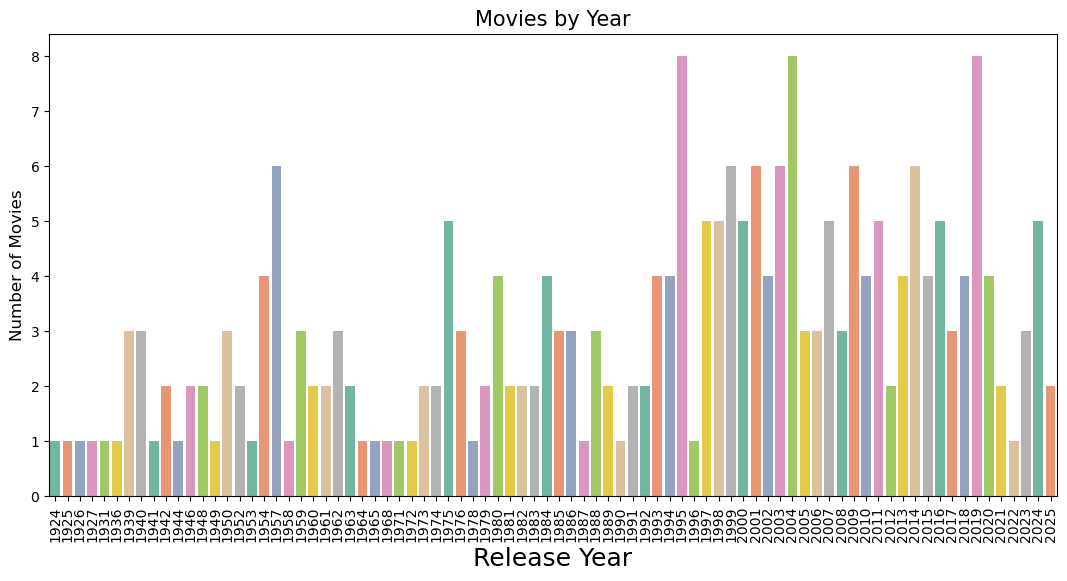

In [16]:
plt.figure(figsize=(13, 6))
sns.countplot(data=df, x='Release Year', palette='Set2')
plt.title('Movies by Year', fontsize=15)
plt.xlabel('Release Year', fontsize=18)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=90)
plt.show()

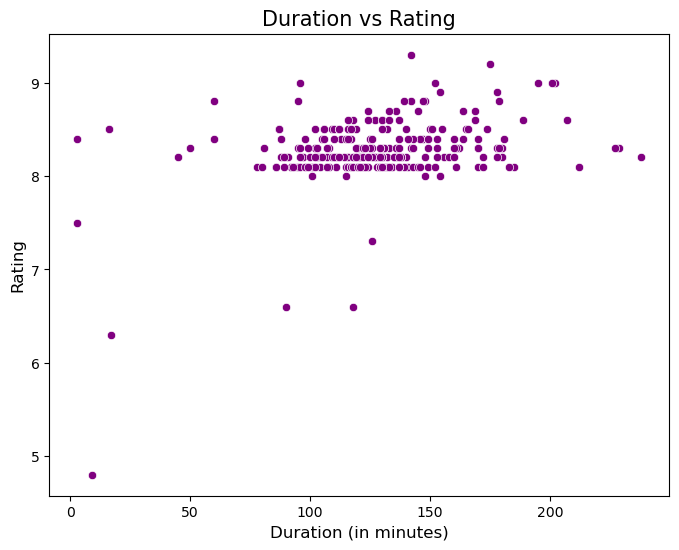

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Duration', y='Rating', color='purple')
plt.title('Duration vs Rating', fontsize=15)
plt.xlabel('Duration (in minutes)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()

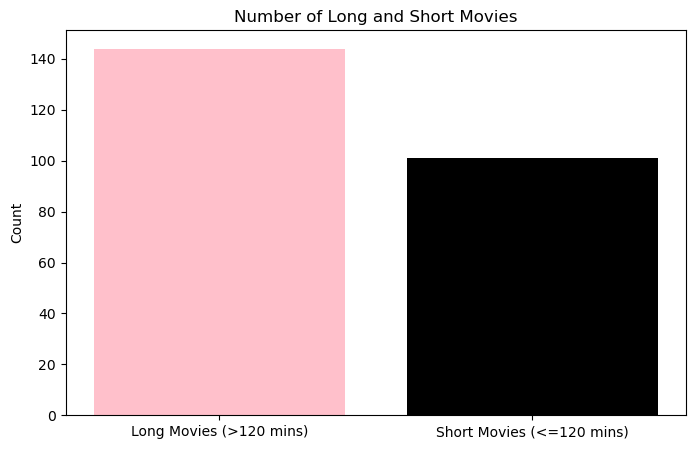

In [18]:
long_movies = df[df['Duration'] > 120]
short_movies = df[df['Duration'] <= 120]

long_short_count = [len(long_movies), len(short_movies)]
categories = ['Long Movies (>120 mins)', 'Short Movies (<=120 mins)']

plt.figure(figsize=(8, 5))
plt.bar(categories, long_short_count, color=['pink', 'black'])
plt.title('Number of Long and Short Movies')
plt.ylabel('Count')
plt.show()

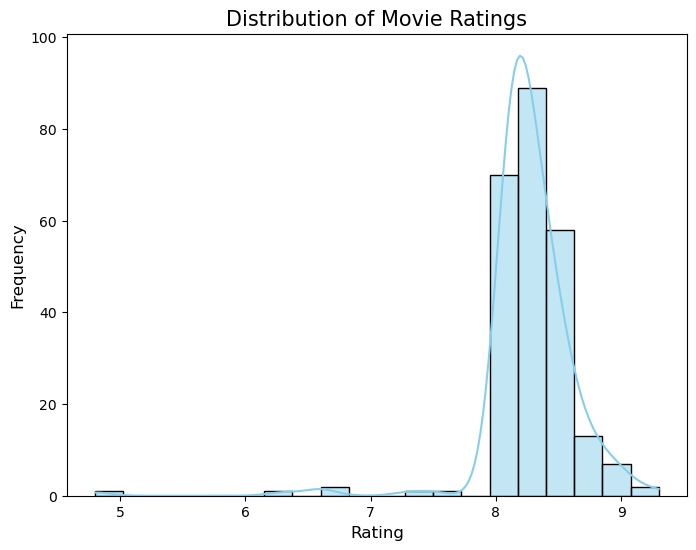

In [19]:
# Rating Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

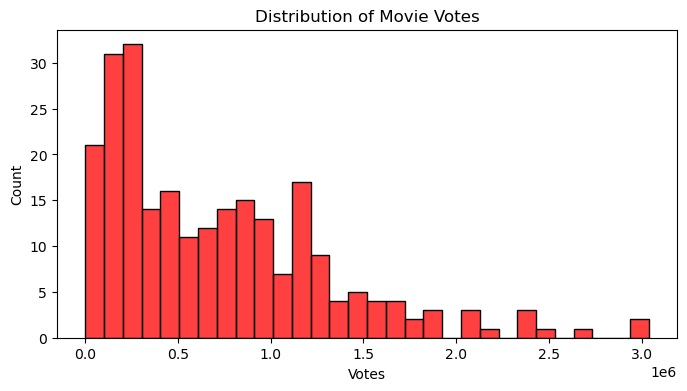

In [20]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Votes'], bins=30, color='red')
plt.title('Distribution of Movie Votes')
plt.xlabel('Votes')
plt.ylabel('Count')
plt.show()

C:\Users\ayaYM\AppData\Local\Temp\ipykernel_20088\2332061190.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='Set2')


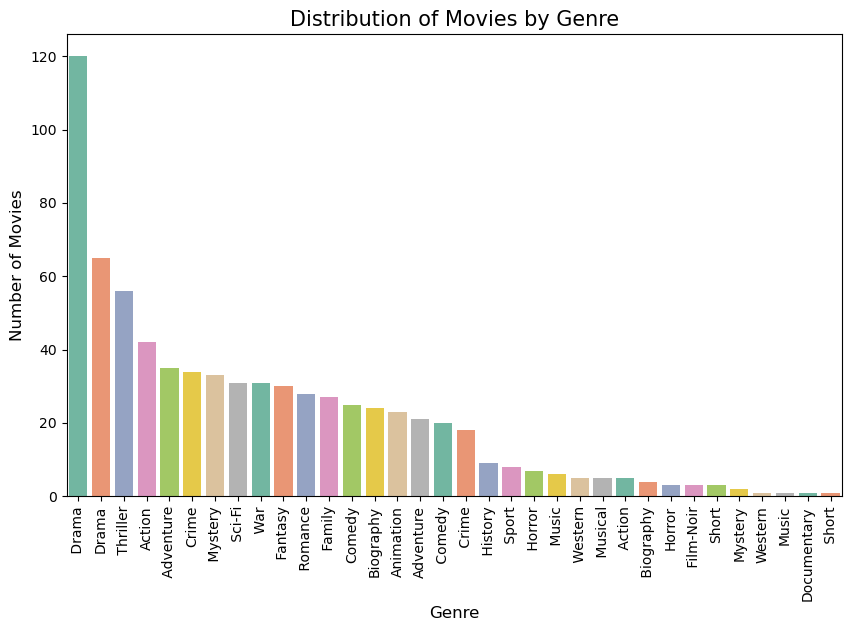

In [21]:
plt.figure(figsize=(10, 6))
genre_counts = df['Genre'].str.split(',').explode().value_counts()
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='Set2')
plt.title('Distribution of Movies by Genre', fontsize=15)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=90)
plt.show()

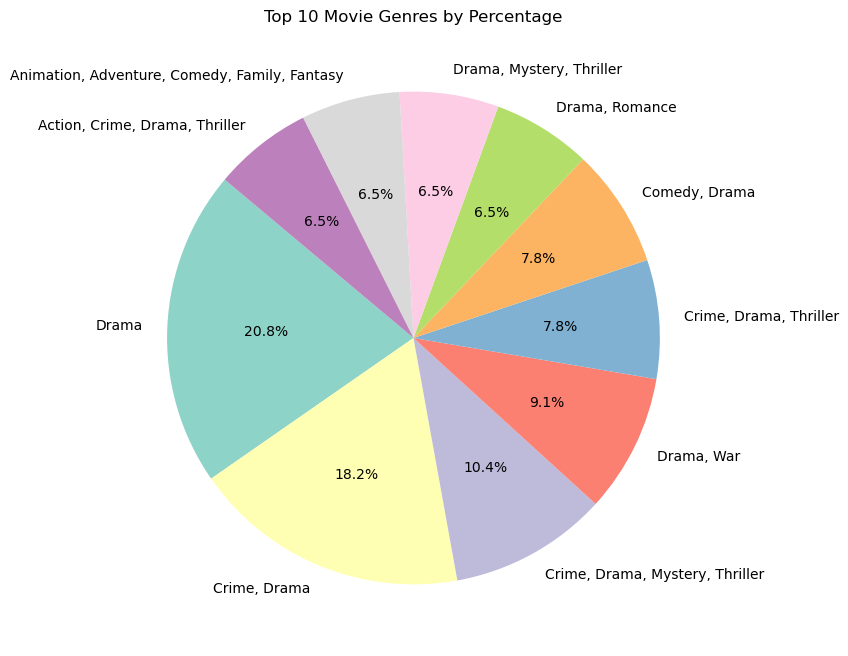

In [22]:
plt.figure(figsize=(8, 8))
genre_percentages = df['Genre'].value_counts(normalize=True).head(10) 
genre_percentages.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('Set3', len(genre_percentages)), startangle=140)
plt.title('Top 10 Movie Genres by Percentage')
plt.ylabel('')  
plt.show()

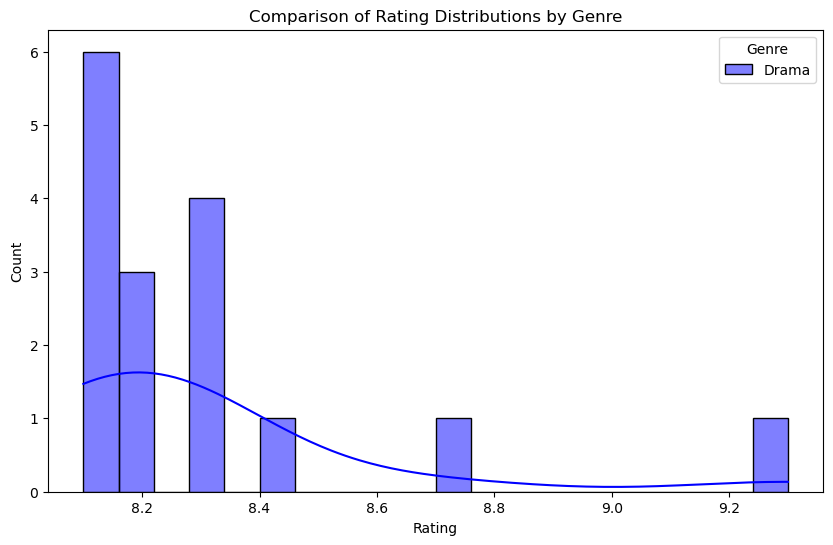

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Genre'] == 'Drama']['Rating'], color='blue', label='Drama', kde=True, bins=20)
sns.histplot(df[df['Genre'] == 'Action']['Rating'], color='red', label='Action', kde=True, bins=20)
plt.legend(title='Genre')
plt.title('Comparison of Rating Distributions by Genre')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

C:\Users\ayaYM\AppData\Local\Temp\ipykernel_20088\2329969713.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_duration.index, y=genre_duration.values, palette='magma')


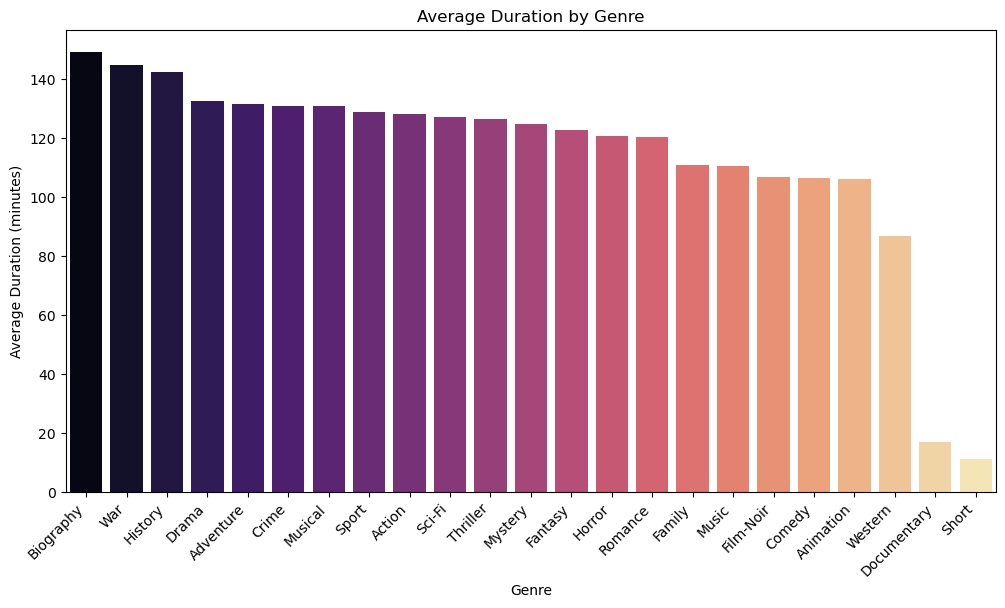

In [24]:
df['Genre'] = df['Genre'].astype(str)

df['Genre'] = df['Genre'].str.split(', ')

expanded_df = df.explode('Genre')

genre_duration = expanded_df.groupby('Genre')['Duration'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_duration.index, y=genre_duration.values, palette='magma')
plt.title('Average Duration by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Duration (minutes)')
plt.xticks(rotation=45, ha='right')
plt.show()


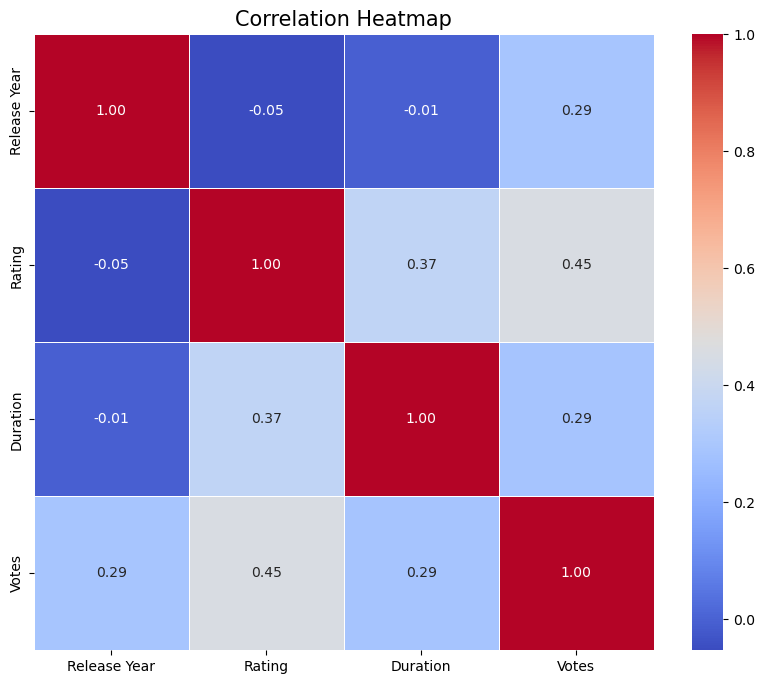

In [25]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[['Release Year', 'Rating', 'Duration', 'Votes']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

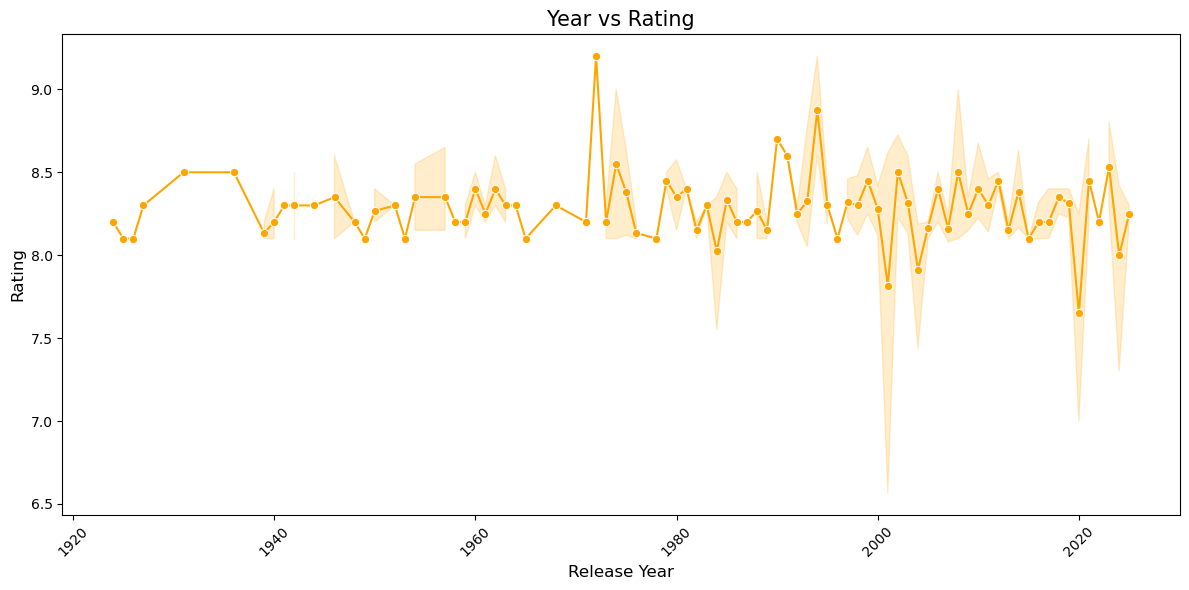

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.sort_values('Release Year'), x='Release Year', y='Rating', marker='o', color='orange')
plt.title('Year vs Rating', fontsize=15)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

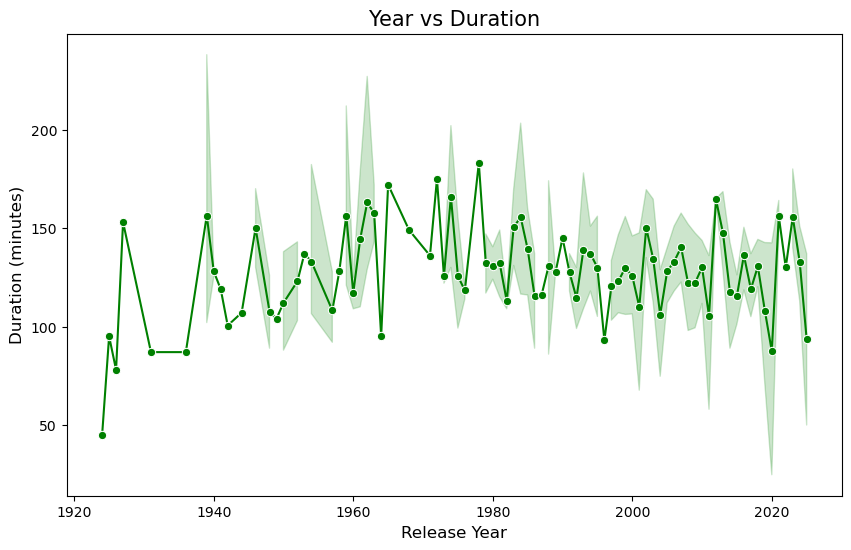

In [27]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Release Year', y='Duration', color='green', marker='o')
plt.title('Year vs Duration', fontsize=15)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.show()

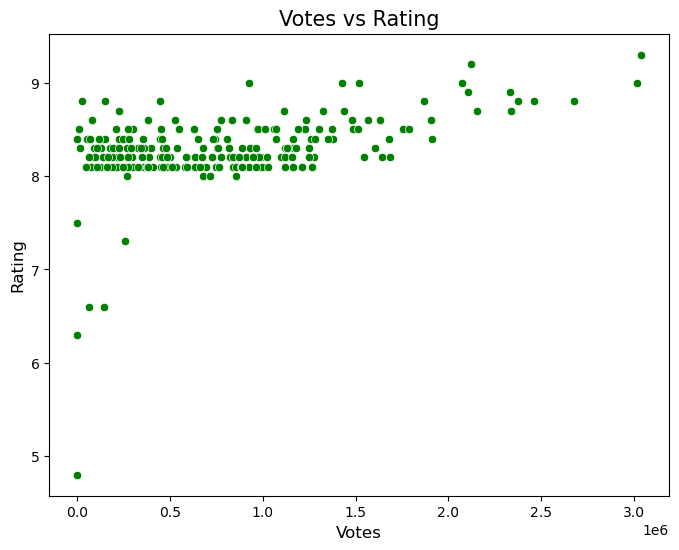

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Votes', y='Rating', color='green')
plt.title('Votes vs Rating', fontsize=15)
plt.xlabel('Votes', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()

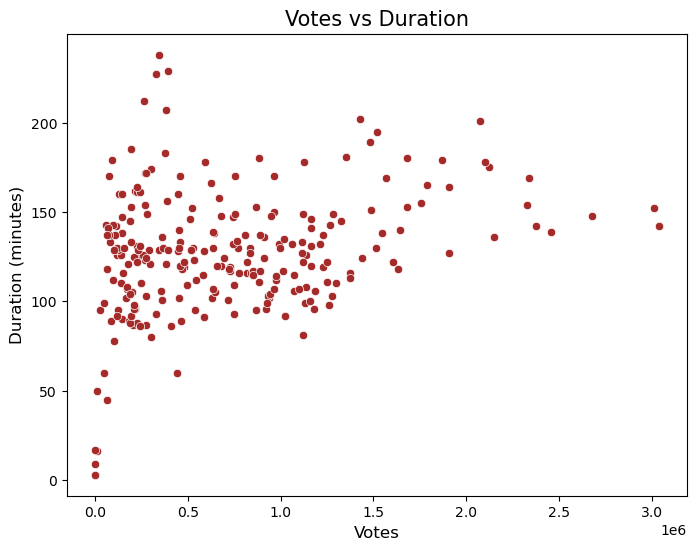

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Votes', y='Duration', color='brown')
plt.title('Votes vs Duration', fontsize=15)
plt.xlabel('Votes', fontsize=12)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.show()

In [31]:
import plotly.express as px


df['Genre'] = df['Genre'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))


fig = px.scatter(
    df,
    x='Votes',
    y='Rating',
    size='Duration',
    color='Genre',
    hover_name='Title',
    title='Votes vs Rating with Duration as Bubble Size',
    size_max=40,
    height=600
)
fig.show()


C:\Users\ayaYM\AppData\Local\Temp\ipykernel_20088\4236412048.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




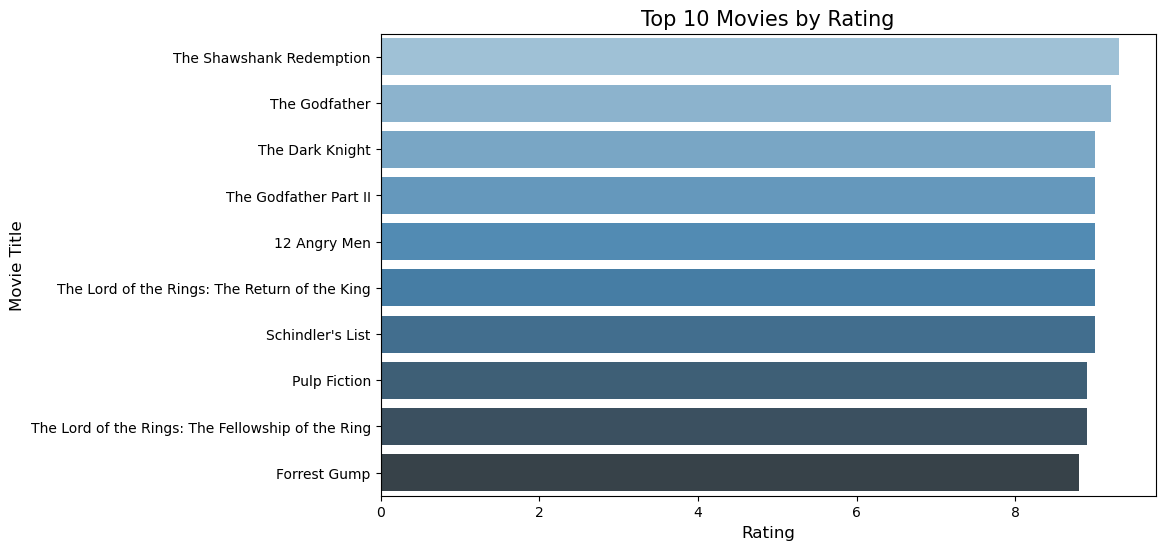

In [32]:
top_10_movies = df.nlargest(10, 'Rating')
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_movies, x='Rating', y='Title', palette='Blues_d')
plt.title('Top 10 Movies by Rating', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.show()

C:\Users\ayaYM\AppData\Local\Temp\ipykernel_20088\1000909042.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




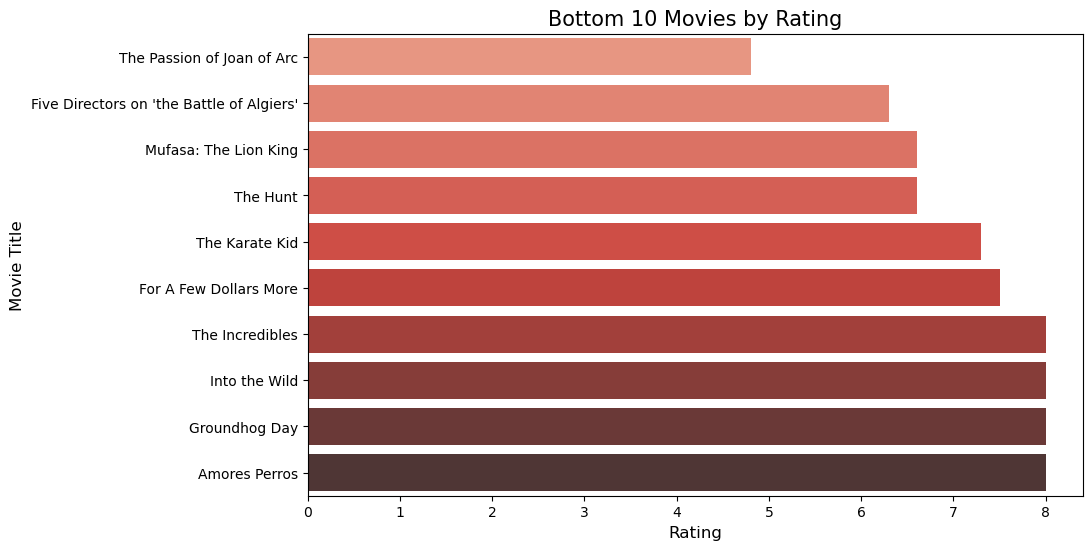

In [33]:
bottom_10_movies = df.nsmallest(10, 'Rating')
plt.figure(figsize=(10, 6))
sns.barplot(data=bottom_10_movies, x='Rating', y='Title', palette='Reds_d')
plt.title('Bottom 10 Movies by Rating', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.show()

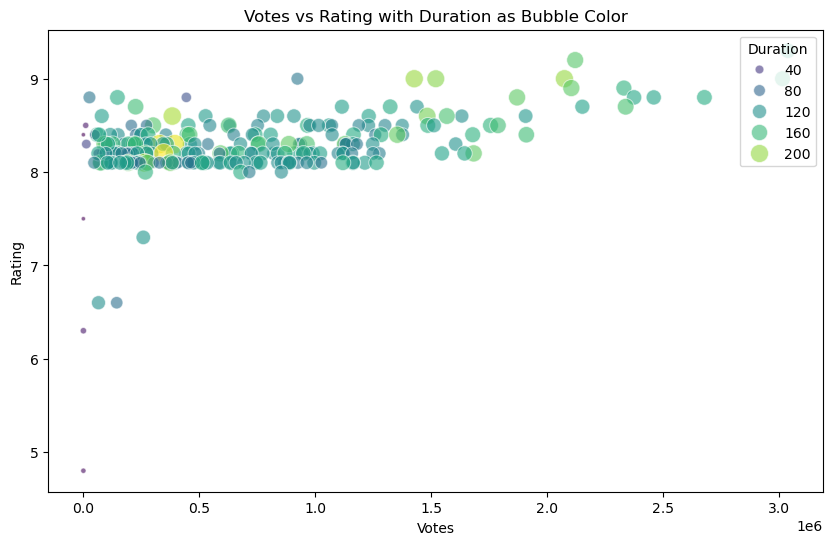

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Votes', y='Rating', hue='Duration', size='Duration', sizes=(10, 200), data=df, palette='viridis', alpha=0.6)
plt.title('Votes vs Rating with Duration as Bubble Color')
plt.xlabel('Votes')
plt.ylabel('Rating')
plt.legend(title='Duration', loc='upper right')
plt.show()

Most Voted Movie: The Shawshank Redemption with 3038741.0 votes
Least Voted Movie: Once Upon a Time in the West with 9.0 votes


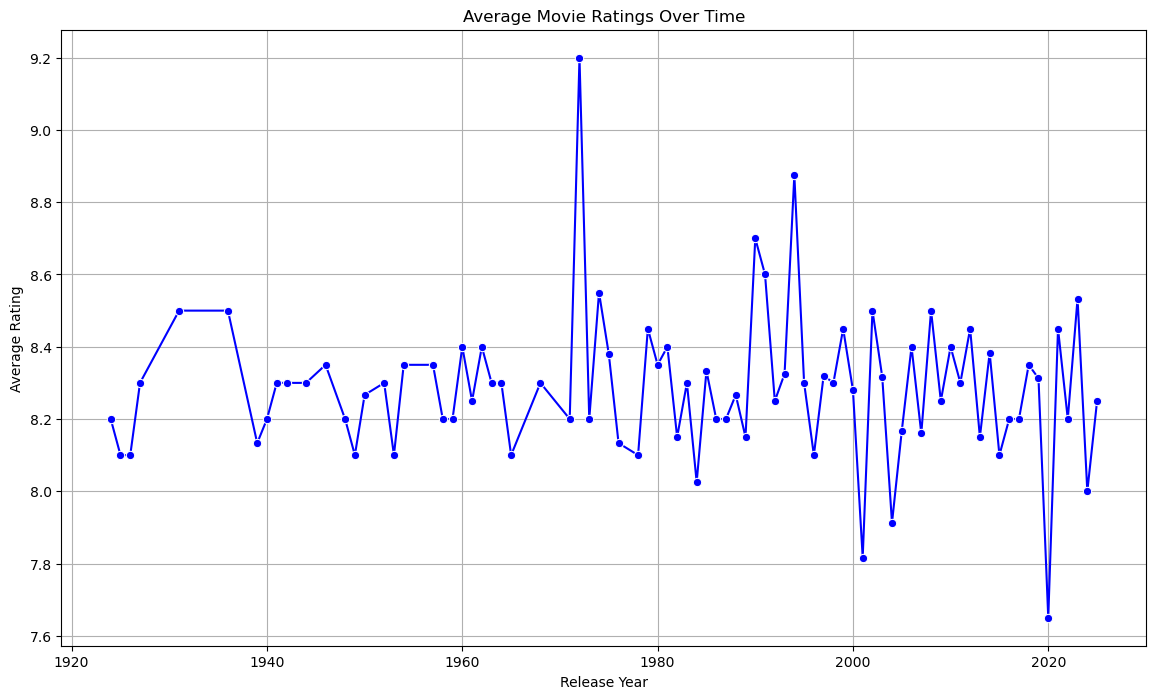

In [35]:
most_voted_movie = df.loc[df['Votes'].idxmax()]
least_voted_movie = df.loc[df['Votes'].idxmin()]

print(f"Most Voted Movie: {most_voted_movie['Title']} with {most_voted_movie['Votes']} votes")
print(f"Least Voted Movie: {least_voted_movie['Title']} with {least_voted_movie['Votes']} votes")

avg_ratings_per_year = df.groupby('Release Year')['Rating'].mean()

plt.figure(figsize=(14, 8))
sns.lineplot(x=avg_ratings_per_year.index, y=avg_ratings_per_year.values, marker='o', color='b')
plt.title('Average Movie Ratings Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

## Apply Regression Model between Duration and Rating

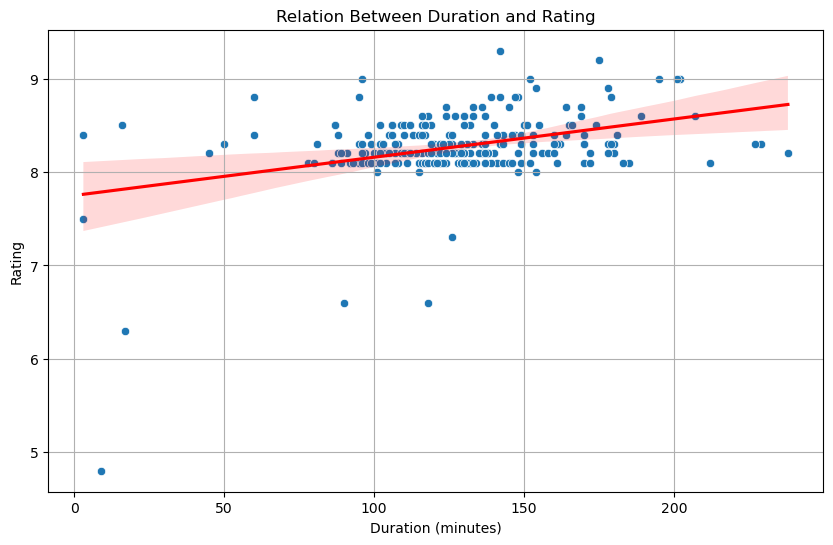

In [36]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['Duration'], y=df['Rating'])
sns.regplot(x=df['Duration'], y=df['Rating'], scatter=False, color='red')
plt.title('Relation Between Duration and Rating')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


In [37]:
X = df[['Duration', 'Votes', 'Release Year']]
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R²):", r2_score(y_test, y_pred))

coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coefficients)

Mean Squared Error (MSE): 0.04691733021967517
R-squared (R²): 0.11523319307697233
        Feature   Coefficient
0      Duration  3.025747e-03
1         Votes  3.005410e-07
2  Release Year -2.908424e-03


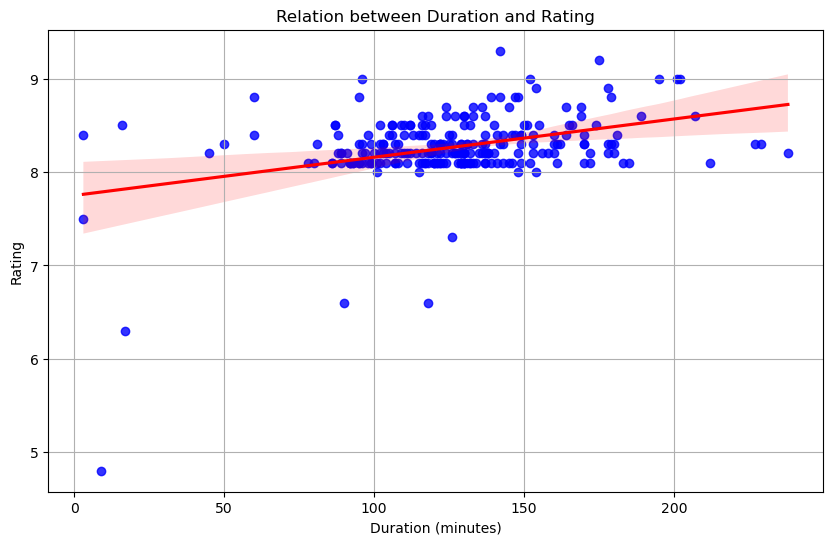

In [38]:
plt.figure(figsize=(10,6))
sns.regplot(x=df['Duration'], y=df['Rating'], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.title('Relation between Duration and Rating')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Multi-variable R-squared Score: {r2:.3f}")
print(f"Multi-variable Mean Squared Error: {mse:.3f}")

Multi-variable R-squared Score: 0.115
Multi-variable Mean Squared Error: 0.047


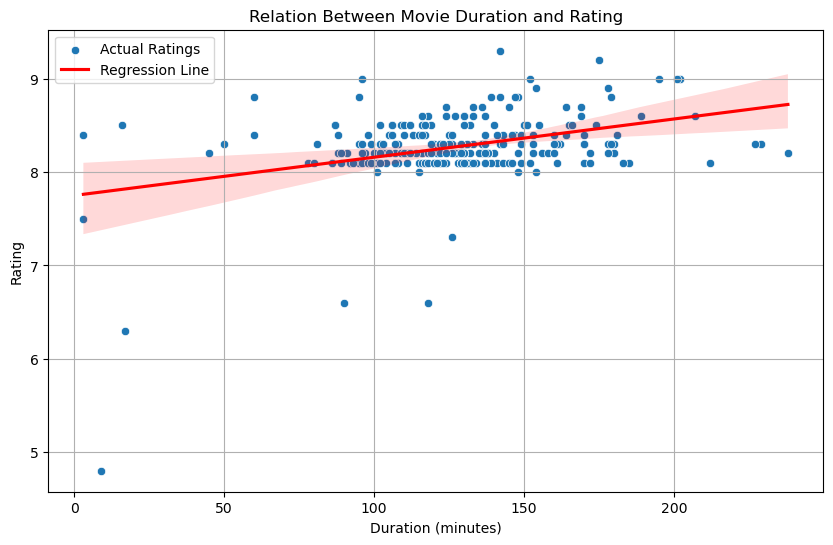

In [40]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['Duration'], y=df['Rating'], label='Actual Ratings')
sns.regplot(x=df['Duration'], y=df['Rating'], scatter=False, color='red', label='Regression Line')
plt.title('Relation Between Movie Duration and Rating')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.legend()
plt.grid(True)
plt.show()


Mean Absolute Error (MAE): 0.160
Root Mean Squared Error (RMSE): 0.217


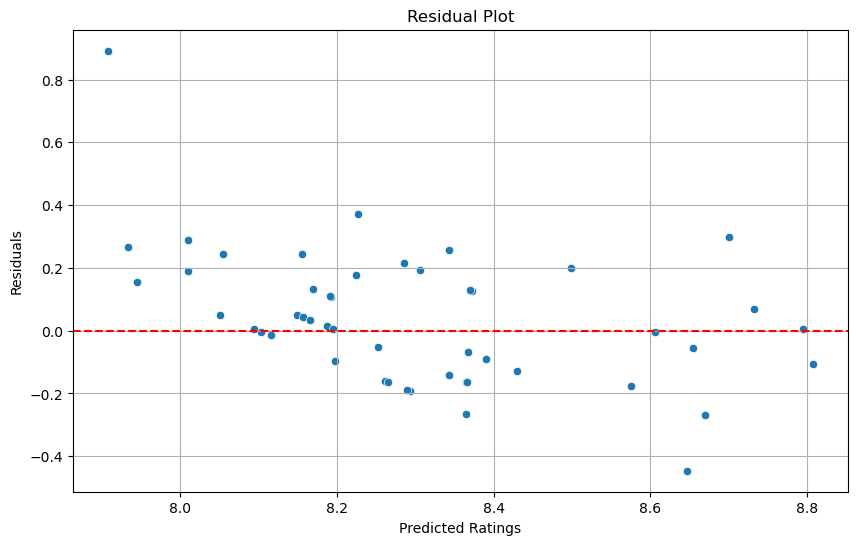

Random Forest R-squared Score: 0.318
Random Forest RMSE: 0.190


In [41]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

residuals = y_test - y_pred

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print(f"Random Forest R-squared Score: {rf_r2:.3f}")
print(f"Random Forest RMSE: {rf_rmse:.3f}")


In [42]:
X = df[['Votes', 'Duration']]  
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [44]:
lr_preds = lr_model.predict(X_test_scaled)
rf_preds = rf_model.predict(X_test)

def evaluate_model(name, y_true, y_pred):
    print(f"--- {name} ---")
    print("R² Score:", r2_score(y_true, y_pred))
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print()

evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Random Forest Regressor", y_test, rf_preds)

--- Linear Regression ---
R² Score: 0.07974754667159245
MSE: 0.0487990597075273
MAE: 0.1688371674860473

--- Random Forest Regressor ---
R² Score: 0.1592204995287564
MSE: 0.04458477551020363
MAE: 0.16379591836734658



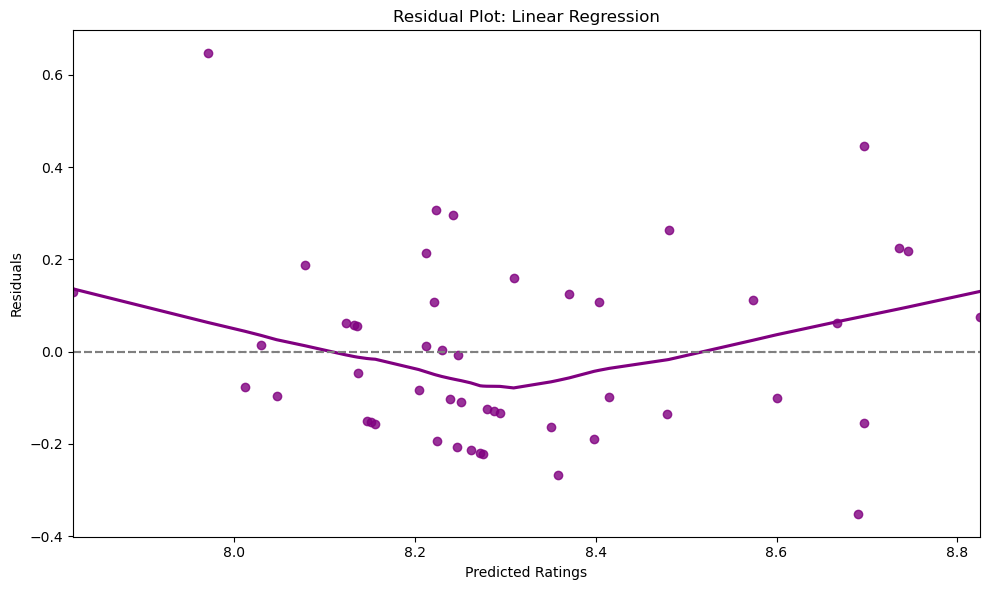

In [45]:
plt.figure(figsize=(10, 6))
sns.residplot(x=lr_preds, y=y_test - lr_preds, lowess=True, color="purple")
plt.title("Residual Plot: Linear Regression")
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

## Data storage

In [46]:
joblib.dump(df, "IMDB_data.joblib")
print("✅ Data saved to IMDB_data.joblib successfully")


✅ Data saved to IMDB_data.joblib successfully


In [47]:
destination_folder = r"C:\Users\ayaYM\Downloads\Streamlit-Last"
destination_path = os.path.join(destination_folder, "IMDB_data.joblib")

shutil.move("IMDB_data.joblib", destination_path)

print("✅ IMDB_data.joblib has been moved to the Streamlit-Last folder")


✅ IMDB_data.joblib has been moved to the Streamlit-Last folder


In [48]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["IMDB_Project"]
collection = db["Movies"]

data = df.to_dict(orient='records')

if data:
    collection.insert_many(data)
    print("✅ Data is stored successfully")
else:
    print("⚠️ No data is stored, the DataFrame is empty.")

✅ Data is stored successfully
